# Pretrained Audio Neural Networks Autoencoder for DCASE‑Inspired Anomalous Sound Detection


In [26]:
# Install dependencies if needed
# !pip install torch torchvision torchaudio librosa tqdm scikit-learn

In [27]:
import os, glob, random, numpy as np
import torch
import torchaudio
import librosa
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score
from tqdm import tqdm


In [ ]:
# Device setup
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)
if DEVICE.type=='cuda': print('GPU:', torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 4090


In [41]:
# ! pip install panns-inference

## Data Prep & PANN Embedding Extraction

In [30]:
TRAIN_WAV = 'DATA/dev_data/dev_data/slider/train'
TEST_WAV  = 'DATA/dev_data/dev_data/slider/test'
EMB_DIR   = 'DATA/embeddings_panns'
os.makedirs(f'{EMB_DIR}/train', exist_ok=True)
os.makedirs(f'{EMB_DIR}/test',  exist_ok=True)

# Import PANNs Inference API
from panns_inference import AudioTagging

# Initialize AudioTagging (uses pretrained CNN14_16k under the hood)
at = AudioTagging(checkpoint_path=None, device=DEVICE)

# Function to extract and save embeddings from PANNs
import torchaudio.functional as Ffunc

def extract_save(wav_list, split):
    out_dir = os.path.join(EMB_DIR, split)
    for wav in tqdm(wav_list, desc=f'Extract {split}', leave=False):
        name = os.path.basename(wav).replace('.wav', '.npy')
        out_path = os.path.join(out_dir, name)
        if os.path.exists(out_path):
            continue
        y, sr = torchaudio.load(wav)
        # PANNs Inference expects 32 kHz
        if sr != 32000:
            y = Ffunc.resample(y, sr, 32000)
        # to numpy batch
        y_np = y.squeeze(0).cpu().numpy()[None, :]
        # get clipwise embedding
        _, emb = at.inference(y_np)
        emb = emb[0]  # shape: [2048]
        np.save(out_path, emb)

# Run extraction on train & test sets
train_files = sorted(glob.glob(os.path.join(TRAIN_WAV, '*.wav')))
test_files  = sorted(glob.glob(os.path.join(TEST_WAV,  '*.wav')))
extract_save(train_files, 'train')
extract_save(test_files,  'test')

Checkpoint path: C:\Users\dell/panns_data/Cnn14_mAP=0.431.pth
Using CPU.


## Dataset & DataLoader

In [31]:
class PannsDataset(Dataset):
    def __init__(self, folder):
        self.files = sorted(glob.glob(os.path.join(folder, '*.npy')))
    def __len__(self): return len(self.files)
    def __getitem__(self, idx):
        arr = np.load(self.files[idx])  # [2048]
        x = torch.tensor(arr, dtype=torch.float32)
        label = 0 if 'normal' in self.files[idx].lower() else 1
        return x, label
BATCH=512
train_ds = PannsDataset(f'{EMB_DIR}/train')
test_ds  = PannsDataset(f'{EMB_DIR}/test')
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=0)
test_dl  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=0)

## Fully‑Connected Autoencoder on PANN Embeddings

In [32]:
INPUT_DIM=2048
HID=512
class PannAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(nn.Linear(INPUT_DIM,HID), nn.ReLU())
        self.dec = nn.Sequential(nn.Linear(HID,INPUT_DIM), nn.ReLU())
    def forward(self,x): return self.dec(self.enc(x))
model = PannAE().to(DEVICE)
print(model)

PannAE(
  (enc): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU()
  )
  (dec): Sequential(
    (0): Linear(in_features=512, out_features=2048, bias=True)
    (1): ReLU()
  )
)


## Training Loop

In [33]:
# Hyperparameters
LR = 1e-3
EPOCHS = 500
PATIENCE = 20  # early stopping patience
MIN_DELTA = 1e-4  
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()
# Reduce LR on plateau if loss saturates
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, 
)

# DataLoaders
# train_dl, test_dl, train_ds should be defined elsewhere

# Training loop with early stopping & checkpointing
best_loss = float('inf')
no_improve = 0
history = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    for x, _ in tqdm(train_dl, desc=f"Epoch {epoch}/{EPOCHS}"):
        x = x.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, x)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * x.size(0)

    epoch_loss = running_loss / len(train_ds)
    history.append(epoch_loss)
    print(f"Epoch {epoch} Loss: {epoch_loss:.6f}")

    # Scheduler step on loss plateau
    scheduler.step(epoch_loss)

    # Early stopping check
    if best_loss - epoch_loss > MIN_DELTA:
        best_loss = epoch_loss
        no_improve = 0
        # Save best model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss
        }, 'best_model.pt')
        print(f"--> New best model saved at epoch {epoch} with loss {epoch_loss:.6f}")
    else:
        no_improve += 1
        print(f"No improvement for {no_improve}/{PATIENCE} epochs.")
        if no_improve >= PATIENCE:
            print(f"Stopping early at epoch {epoch} due to no improvement.")
            break


Epoch 1/500: 100%|██████████| 5/5 [00:00<00:00,  6.38it/s]


Epoch 1 Loss: 0.038053
--> New best model saved at epoch 1 with loss 0.038053


Epoch 2/500: 100%|██████████| 5/5 [00:00<00:00,  7.93it/s]


Epoch 2 Loss: 0.017384
--> New best model saved at epoch 2 with loss 0.017384


Epoch 3/500: 100%|██████████| 5/5 [00:00<00:00,  7.78it/s]


Epoch 3 Loss: 0.014589
--> New best model saved at epoch 3 with loss 0.014589


Epoch 4/500: 100%|██████████| 5/5 [00:00<00:00,  7.94it/s]


Epoch 4 Loss: 0.011824
--> New best model saved at epoch 4 with loss 0.011824


Epoch 5/500: 100%|██████████| 5/5 [00:00<00:00,  7.99it/s]


Epoch 5 Loss: 0.010031
--> New best model saved at epoch 5 with loss 0.010031


Epoch 6/500: 100%|██████████| 5/5 [00:00<00:00,  8.06it/s]


Epoch 6 Loss: 0.009042
--> New best model saved at epoch 6 with loss 0.009042


Epoch 7/500: 100%|██████████| 5/5 [00:00<00:00,  8.10it/s]


Epoch 7 Loss: 0.008184
--> New best model saved at epoch 7 with loss 0.008184


Epoch 8/500: 100%|██████████| 5/5 [00:00<00:00,  8.16it/s]


Epoch 8 Loss: 0.007447
--> New best model saved at epoch 8 with loss 0.007447


Epoch 9/500: 100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


Epoch 9 Loss: 0.006899
--> New best model saved at epoch 9 with loss 0.006899


Epoch 10/500: 100%|██████████| 5/5 [00:00<00:00,  8.06it/s]


Epoch 10 Loss: 0.006501
--> New best model saved at epoch 10 with loss 0.006501


Epoch 11/500: 100%|██████████| 5/5 [00:00<00:00,  8.03it/s]


Epoch 11 Loss: 0.006209
--> New best model saved at epoch 11 with loss 0.006209


Epoch 12/500: 100%|██████████| 5/5 [00:00<00:00,  8.16it/s]


Epoch 12 Loss: 0.005960
--> New best model saved at epoch 12 with loss 0.005960


Epoch 13/500: 100%|██████████| 5/5 [00:00<00:00,  7.97it/s]


Epoch 13 Loss: 0.005766
--> New best model saved at epoch 13 with loss 0.005766


Epoch 14/500: 100%|██████████| 5/5 [00:00<00:00,  7.83it/s]


Epoch 14 Loss: 0.005588
--> New best model saved at epoch 14 with loss 0.005588


Epoch 15/500: 100%|██████████| 5/5 [00:00<00:00,  8.14it/s]


Epoch 15 Loss: 0.005443
--> New best model saved at epoch 15 with loss 0.005443


Epoch 16/500: 100%|██████████| 5/5 [00:00<00:00,  8.11it/s]


Epoch 16 Loss: 0.005281
--> New best model saved at epoch 16 with loss 0.005281


Epoch 17/500: 100%|██████████| 5/5 [00:00<00:00,  7.93it/s]


Epoch 17 Loss: 0.005121
--> New best model saved at epoch 17 with loss 0.005121


Epoch 18/500: 100%|██████████| 5/5 [00:00<00:00,  8.24it/s]


Epoch 18 Loss: 0.004992
--> New best model saved at epoch 18 with loss 0.004992


Epoch 19/500: 100%|██████████| 5/5 [00:00<00:00,  7.75it/s]


Epoch 19 Loss: 0.004886
--> New best model saved at epoch 19 with loss 0.004886


Epoch 20/500: 100%|██████████| 5/5 [00:00<00:00,  8.20it/s]


Epoch 20 Loss: 0.004798
No improvement for 1/20 epochs.


Epoch 21/500: 100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


Epoch 21 Loss: 0.004720
--> New best model saved at epoch 21 with loss 0.004720


Epoch 22/500: 100%|██████████| 5/5 [00:00<00:00,  8.19it/s]


Epoch 22 Loss: 0.004625
No improvement for 1/20 epochs.


Epoch 23/500: 100%|██████████| 5/5 [00:00<00:00,  7.71it/s]


Epoch 23 Loss: 0.004464
--> New best model saved at epoch 23 with loss 0.004464


Epoch 24/500: 100%|██████████| 5/5 [00:00<00:00,  8.22it/s]


Epoch 24 Loss: 0.004355
--> New best model saved at epoch 24 with loss 0.004355


Epoch 25/500: 100%|██████████| 5/5 [00:00<00:00,  7.94it/s]


Epoch 25 Loss: 0.004283
No improvement for 1/20 epochs.


Epoch 26/500: 100%|██████████| 5/5 [00:00<00:00,  8.09it/s]


Epoch 26 Loss: 0.004224
--> New best model saved at epoch 26 with loss 0.004224


Epoch 27/500: 100%|██████████| 5/5 [00:00<00:00,  8.05it/s]


Epoch 27 Loss: 0.004169
No improvement for 1/20 epochs.


Epoch 28/500: 100%|██████████| 5/5 [00:00<00:00,  7.47it/s]


Epoch 28 Loss: 0.004121
--> New best model saved at epoch 28 with loss 0.004121


Epoch 29/500: 100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


Epoch 29 Loss: 0.004077
No improvement for 1/20 epochs.


Epoch 30/500: 100%|██████████| 5/5 [00:00<00:00,  8.13it/s]


Epoch 30 Loss: 0.004035
No improvement for 2/20 epochs.


Epoch 31/500: 100%|██████████| 5/5 [00:00<00:00,  7.84it/s]


Epoch 31 Loss: 0.003997
--> New best model saved at epoch 31 with loss 0.003997


Epoch 32/500: 100%|██████████| 5/5 [00:00<00:00,  6.53it/s]


Epoch 32 Loss: 0.003960
No improvement for 1/20 epochs.


Epoch 33/500: 100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


Epoch 33 Loss: 0.003926
No improvement for 2/20 epochs.


Epoch 34/500: 100%|██████████| 5/5 [00:00<00:00,  7.88it/s]


Epoch 34 Loss: 0.003894
--> New best model saved at epoch 34 with loss 0.003894


Epoch 35/500: 100%|██████████| 5/5 [00:00<00:00,  8.14it/s]


Epoch 35 Loss: 0.003846
No improvement for 1/20 epochs.


Epoch 36/500: 100%|██████████| 5/5 [00:00<00:00,  8.01it/s]


Epoch 36 Loss: 0.003801
No improvement for 2/20 epochs.


Epoch 37/500: 100%|██████████| 5/5 [00:00<00:00,  7.72it/s]


Epoch 37 Loss: 0.003770
--> New best model saved at epoch 37 with loss 0.003770


Epoch 38/500: 100%|██████████| 5/5 [00:00<00:00,  8.04it/s]


Epoch 38 Loss: 0.003743
No improvement for 1/20 epochs.


Epoch 39/500: 100%|██████████| 5/5 [00:00<00:00,  8.10it/s]


Epoch 39 Loss: 0.003716
No improvement for 2/20 epochs.


Epoch 40/500: 100%|██████████| 5/5 [00:00<00:00,  7.90it/s]


Epoch 40 Loss: 0.003690
No improvement for 3/20 epochs.


Epoch 41/500: 100%|██████████| 5/5 [00:00<00:00,  8.10it/s]


Epoch 41 Loss: 0.003666
--> New best model saved at epoch 41 with loss 0.003666


Epoch 42/500: 100%|██████████| 5/5 [00:00<00:00,  7.99it/s]


Epoch 42 Loss: 0.003643
No improvement for 1/20 epochs.


Epoch 43/500: 100%|██████████| 5/5 [00:00<00:00,  7.72it/s]


Epoch 43 Loss: 0.003622
No improvement for 2/20 epochs.


Epoch 44/500: 100%|██████████| 5/5 [00:00<00:00,  7.88it/s]


Epoch 44 Loss: 0.003601
No improvement for 3/20 epochs.


Epoch 45/500: 100%|██████████| 5/5 [00:00<00:00,  8.06it/s]


Epoch 45 Loss: 0.003581
No improvement for 4/20 epochs.


Epoch 46/500: 100%|██████████| 5/5 [00:00<00:00,  7.96it/s]


Epoch 46 Loss: 0.003561
--> New best model saved at epoch 46 with loss 0.003561


Epoch 47/500: 100%|██████████| 5/5 [00:00<00:00,  7.96it/s]


Epoch 47 Loss: 0.003543
No improvement for 1/20 epochs.


Epoch 48/500: 100%|██████████| 5/5 [00:00<00:00,  7.94it/s]


Epoch 48 Loss: 0.003525
No improvement for 2/20 epochs.


Epoch 49/500: 100%|██████████| 5/5 [00:00<00:00,  8.10it/s]


Epoch 49 Loss: 0.003508
No improvement for 3/20 epochs.


Epoch 50/500: 100%|██████████| 5/5 [00:00<00:00,  7.87it/s]


Epoch 50 Loss: 0.003492
No improvement for 4/20 epochs.


Epoch 51/500: 100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


Epoch 51 Loss: 0.003476
No improvement for 5/20 epochs.


Epoch 52/500: 100%|██████████| 5/5 [00:00<00:00,  7.89it/s]


Epoch 52 Loss: 0.003462
No improvement for 6/20 epochs.


Epoch 53/500: 100%|██████████| 5/5 [00:00<00:00,  7.90it/s]


Epoch 53 Loss: 0.003447
--> New best model saved at epoch 53 with loss 0.003447


Epoch 54/500: 100%|██████████| 5/5 [00:00<00:00,  8.03it/s]


Epoch 54 Loss: 0.003434
No improvement for 1/20 epochs.


Epoch 55/500: 100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


Epoch 55 Loss: 0.003420
No improvement for 2/20 epochs.


Epoch 56/500: 100%|██████████| 5/5 [00:00<00:00,  8.00it/s]


Epoch 56 Loss: 0.003407
No improvement for 3/20 epochs.


Epoch 57/500: 100%|██████████| 5/5 [00:00<00:00,  7.82it/s]


Epoch 57 Loss: 0.003277
--> New best model saved at epoch 57 with loss 0.003277


Epoch 58/500: 100%|██████████| 5/5 [00:00<00:00,  7.75it/s]


Epoch 58 Loss: 0.003173
--> New best model saved at epoch 58 with loss 0.003173


Epoch 59/500: 100%|██████████| 5/5 [00:00<00:00,  7.96it/s]


Epoch 59 Loss: 0.003136
No improvement for 1/20 epochs.


Epoch 60/500: 100%|██████████| 5/5 [00:00<00:00,  8.02it/s]


Epoch 60 Loss: 0.003102
No improvement for 2/20 epochs.


Epoch 61/500: 100%|██████████| 5/5 [00:00<00:00,  7.98it/s]


Epoch 61 Loss: 0.003080
No improvement for 3/20 epochs.


Epoch 62/500: 100%|██████████| 5/5 [00:00<00:00,  8.29it/s]


Epoch 62 Loss: 0.003065
--> New best model saved at epoch 62 with loss 0.003065


Epoch 63/500: 100%|██████████| 5/5 [00:00<00:00,  7.93it/s]


Epoch 63 Loss: 0.003053
No improvement for 1/20 epochs.


Epoch 64/500: 100%|██████████| 5/5 [00:00<00:00,  8.12it/s]


Epoch 64 Loss: 0.003040
No improvement for 2/20 epochs.


Epoch 65/500: 100%|██████████| 5/5 [00:00<00:00,  8.09it/s]


Epoch 65 Loss: 0.003028
No improvement for 3/20 epochs.


Epoch 66/500: 100%|██████████| 5/5 [00:00<00:00,  8.14it/s]


Epoch 66 Loss: 0.003018
No improvement for 4/20 epochs.


Epoch 67/500: 100%|██████████| 5/5 [00:00<00:00,  7.89it/s]


Epoch 67 Loss: 0.003008
No improvement for 5/20 epochs.


Epoch 68/500: 100%|██████████| 5/5 [00:00<00:00,  8.09it/s]


Epoch 68 Loss: 0.002999
No improvement for 6/20 epochs.


Epoch 69/500: 100%|██████████| 5/5 [00:00<00:00,  8.04it/s]


Epoch 69 Loss: 0.002990
No improvement for 7/20 epochs.


Epoch 70/500: 100%|██████████| 5/5 [00:00<00:00,  7.88it/s]


Epoch 70 Loss: 0.002981
No improvement for 8/20 epochs.


Epoch 71/500: 100%|██████████| 5/5 [00:00<00:00,  7.90it/s]


Epoch 71 Loss: 0.002973
No improvement for 9/20 epochs.


Epoch 72/500: 100%|██████████| 5/5 [00:00<00:00,  7.53it/s]


Epoch 72 Loss: 0.002965
No improvement for 10/20 epochs.


Epoch 73/500: 100%|██████████| 5/5 [00:00<00:00,  7.84it/s]


Epoch 73 Loss: 0.002958
--> New best model saved at epoch 73 with loss 0.002958


Epoch 74/500: 100%|██████████| 5/5 [00:00<00:00,  8.01it/s]


Epoch 74 Loss: 0.002950
No improvement for 1/20 epochs.


Epoch 75/500: 100%|██████████| 5/5 [00:00<00:00,  8.28it/s]


Epoch 75 Loss: 0.002943
No improvement for 2/20 epochs.


Epoch 76/500: 100%|██████████| 5/5 [00:00<00:00,  8.14it/s]


Epoch 76 Loss: 0.002936
No improvement for 3/20 epochs.


Epoch 77/500: 100%|██████████| 5/5 [00:00<00:00,  8.31it/s]


Epoch 77 Loss: 0.002929
No improvement for 4/20 epochs.


Epoch 78/500: 100%|██████████| 5/5 [00:00<00:00,  7.98it/s]


Epoch 78 Loss: 0.002922
No improvement for 5/20 epochs.


Epoch 79/500: 100%|██████████| 5/5 [00:00<00:00,  8.03it/s]


Epoch 79 Loss: 0.002915
No improvement for 6/20 epochs.


Epoch 80/500: 100%|██████████| 5/5 [00:00<00:00,  7.91it/s]


Epoch 80 Loss: 0.002900
No improvement for 7/20 epochs.


Epoch 81/500: 100%|██████████| 5/5 [00:00<00:00,  8.09it/s]


Epoch 81 Loss: 0.002888
No improvement for 8/20 epochs.


Epoch 82/500: 100%|██████████| 5/5 [00:00<00:00,  8.11it/s]


Epoch 82 Loss: 0.002880
No improvement for 9/20 epochs.


Epoch 83/500: 100%|██████████| 5/5 [00:00<00:00,  8.09it/s]


Epoch 83 Loss: 0.002874
No improvement for 10/20 epochs.


Epoch 84/500: 100%|██████████| 5/5 [00:00<00:00,  7.92it/s]


Epoch 84 Loss: 0.002868
No improvement for 11/20 epochs.


Epoch 85/500: 100%|██████████| 5/5 [00:00<00:00,  7.81it/s]


Epoch 85 Loss: 0.002862
No improvement for 12/20 epochs.


Epoch 86/500: 100%|██████████| 5/5 [00:00<00:00,  7.79it/s]


Epoch 86 Loss: 0.002855
--> New best model saved at epoch 86 with loss 0.002855


Epoch 87/500: 100%|██████████| 5/5 [00:00<00:00,  6.16it/s]


Epoch 87 Loss: 0.002850
No improvement for 1/20 epochs.


Epoch 88/500: 100%|██████████| 5/5 [00:00<00:00,  8.33it/s]


Epoch 88 Loss: 0.002843
No improvement for 2/20 epochs.


Epoch 89/500: 100%|██████████| 5/5 [00:00<00:00,  8.02it/s]


Epoch 89 Loss: 0.002838
No improvement for 3/20 epochs.


Epoch 90/500: 100%|██████████| 5/5 [00:00<00:00,  8.57it/s]


Epoch 90 Loss: 0.002833
No improvement for 4/20 epochs.


Epoch 91/500: 100%|██████████| 5/5 [00:00<00:00,  8.62it/s]


Epoch 91 Loss: 0.002827
No improvement for 5/20 epochs.


Epoch 92/500: 100%|██████████| 5/5 [00:00<00:00,  8.87it/s]


Epoch 92 Loss: 0.002823
No improvement for 6/20 epochs.


Epoch 93/500: 100%|██████████| 5/5 [00:00<00:00,  8.55it/s]


Epoch 93 Loss: 0.002818
No improvement for 7/20 epochs.


Epoch 94/500: 100%|██████████| 5/5 [00:00<00:00,  8.59it/s]


Epoch 94 Loss: 0.002813
No improvement for 8/20 epochs.


Epoch 95/500: 100%|██████████| 5/5 [00:00<00:00,  8.31it/s]


Epoch 95 Loss: 0.002809
No improvement for 9/20 epochs.


Epoch 96/500: 100%|██████████| 5/5 [00:00<00:00,  7.95it/s]


Epoch 96 Loss: 0.002804
No improvement for 10/20 epochs.


Epoch 97/500: 100%|██████████| 5/5 [00:00<00:00,  8.08it/s]


Epoch 97 Loss: 0.002800
No improvement for 11/20 epochs.


Epoch 98/500: 100%|██████████| 5/5 [00:00<00:00,  7.84it/s]


Epoch 98 Loss: 0.002796
No improvement for 12/20 epochs.


Epoch 99/500: 100%|██████████| 5/5 [00:00<00:00,  7.74it/s]


Epoch 99 Loss: 0.002792
No improvement for 13/20 epochs.


Epoch 100/500: 100%|██████████| 5/5 [00:00<00:00,  7.97it/s]


Epoch 100 Loss: 0.002788
No improvement for 14/20 epochs.


Epoch 101/500: 100%|██████████| 5/5 [00:00<00:00,  8.11it/s]


Epoch 101 Loss: 0.002783
No improvement for 15/20 epochs.


Epoch 102/500: 100%|██████████| 5/5 [00:00<00:00,  7.32it/s]


Epoch 102 Loss: 0.002780
No improvement for 16/20 epochs.


Epoch 103/500: 100%|██████████| 5/5 [00:00<00:00,  7.90it/s]


Epoch 103 Loss: 0.002776
No improvement for 17/20 epochs.


Epoch 104/500: 100%|██████████| 5/5 [00:00<00:00,  7.89it/s]


Epoch 104 Loss: 0.002772
No improvement for 18/20 epochs.


Epoch 105/500: 100%|██████████| 5/5 [00:00<00:00,  8.10it/s]


Epoch 105 Loss: 0.002768
No improvement for 19/20 epochs.


Epoch 106/500: 100%|██████████| 5/5 [00:00<00:00,  8.12it/s]

Epoch 106 Loss: 0.002765
No improvement for 20/20 epochs.
Stopping early at epoch 106 due to no improvement.


## Plot Training Loss

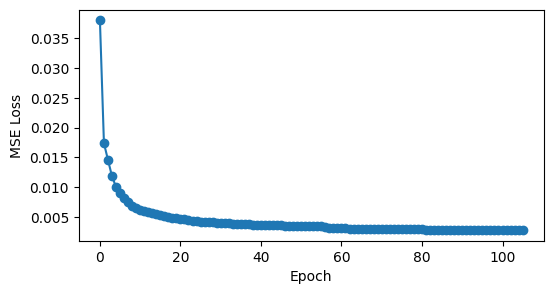

In [37]:
plt.figure(figsize=(6,3))
plt.plot(history,marker='o')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

## Inference & AUC

In [38]:
# Load best model for inference
checkpoint = torch.load('best_model.pt', map_location=DEVICE)
model = PannAE().to(DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Inference and evaluation
scores, labels = [], []
with torch.no_grad():
    for x, y in tqdm(test_dl, desc='Test'):  # evaluation
        x = x.to(DEVICE)
        recon = model(x)
        err = ((x - recon) ** 2).mean(dim=1).cpu().numpy()
        scores.extend(err)
        labels.extend(y.numpy())

auc = roc_auc_score(labels, scores)
print(f"Test AUC: {auc:.4f}")


Test: 100%|██████████| 3/3 [00:00<00:00, 11.01it/s]

Test AUC: 0.8845


## Error Distribution

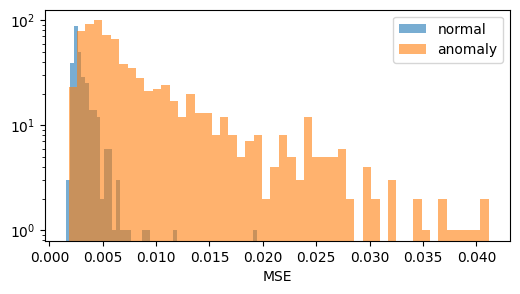

In [39]:
norm=[s for s,l in zip(scores,labels) if l==0]
anom=[s for s,l in zip(scores,labels) if l==1]
plt.figure(figsize=(6,3))
plt.hist(norm,bins=50,alpha=0.6,label='normal',log=True)
plt.hist(anom,bins=50,alpha=0.6,label='anomaly',log=True)
plt.xlabel('MSE')
plt.legend()
plt.show()

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = nn.MSELoss()
EPOCHS = 500

# Scheduler + early-stop params
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    opt, mode='min', factor=0.5, patience=10, verbose=True
)
patience = 20      
min_delta = 1e-4 

history = []
best_loss = float('inf')
stale_epochs = 0

for ep in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    for x, _ in tqdm(train_dl, desc=f'Epoch {ep}/{EPOCHS}', leave=False):
        x = x.to(DEVICE)
        opt.zero_grad()
        out = model(x)
        loss = crit(out, x)
        loss.backward()
        opt.step()
        total_loss += loss.item() * x.size(0)

    avg = total_loss / len(train_ds)
    history.append(avg)
    print(f'Epoch {ep:2d} loss={avg:.6f}')

    # step the LR scheduler on the validation metric (here train loss)
    scheduler.step(avg)

    # early-stopping check
    if best_loss - avg > min_delta:
        best_loss = avg
        stale_epochs = 0
        print(f"  ↳ Improvement detected (new best_loss={best_loss:.6f}). Patience reset.")
    else:
        stale_epochs += 1
        print(f"  ↳ No significant improvement for {stale_epochs}/{patience} epochs.")
        if stale_epochs >= patience:
            print(f"Early stopping at epoch {ep}: no loss decrease >{min_delta} for {patience} epochs.")
            break
